<img src="static/event-image-small.jpg" alt="drawing" width="800"/> 

# **LAB 1: DATA PREPARATION**

In this notebook, we will explore how do prepare data for downstream NLP tasks.  

A non-exhaustive list tasks related to NLP and Generative AI that can benefit from this data
preparation is:

- Question & Answer
- Text Summarization
- Instruct Tuning
- Human-Bot Conversations
- Continued PreTraining


For each of these tasks, there are subtle differences in how one might want to prepare the data.
Some of the key steps one might use here for data prep are also applicable to 
applying guardrails to LLMs (e.g., `Profanity Check` and `Toxicity Detection`)

More on guardrails in Lab #5, but for now let's import our required python 
libraries and get started!


# Import Required Dependencies 

In [1]:
import warnings
warnings.filterwarnings('ignore')

# set flag for training environment
TRAINING = True

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd 
import numpy as np

import matplotlib

# Dataset

For most of this training we will focus on a public dataset that focuses on text content
and metadata for LinkedIn posts during 2021. These posts were collected from the
internet and correspond to a wide array of identified "influencers".

The data set can be found at: https://www.kaggle.com/datasets/shreyasajal/linkedin-influencers-data

Noticeably, this dataset has seen a spike of new downloads in the last few weeks, 
perhaps related to an increased awareness of possible llm applications



<img src="static/data-downloads.png" alt="drawing" width="800"/> 

# Import Dataset

For convenience, H2O.ai has downloaded this dataset and placed it on a public
bucket on AWS S3. Let's read it in and take a look!

In [2]:
# Read in from public S3 Location
df = pd.read_csv("s3a://h2o-public-test-data/generative-ai/influencers_data.csv")
df.tail()

,name,headline,location,followers,connections,about,time_spent,content,content_links,media_type,media_url,num_hashtags,hashtag_followers,hashtags,reactions,comments,views,votes
34007,Simon Sinek,Optimist and Author at Simon Sinek Inc.,NaN,4206024.0,NaN,Simon Sinek is an unshakable optimist who beli...,4 years ago,Igniter of the Year 2016. Well I know that I'm...,[],image,['https://media-exp1.licdn.com/dms/image/C5622...,0,0,[],4005,93,NaN,NaN
34008,Simon Sinek,Optimist and Author at Simon Sinek Inc.,NaN,4206024.0,NaN,Simon Sinek is an unshakable optimist who beli...,4 years ago,Executives who prioritize the shareholder are ...,[],video,[],0,0,[],1698,74,NaN,NaN
34009,Simon Sinek,Optimist and Author at Simon Sinek Inc.,NaN,4206024.0,NaN,Simon Sinek is an unshakable optimist who beli...,4 years ago,"Like many, I too have been reflecting as we ne...",[],video,[],0,0,[],661,59,NaN,NaN
34010,Simon Sinek,Optimist and Author at Simon Sinek Inc.,NaN,4206024.0,NaN,Simon Sinek is an unshakable optimist who beli...,4 years ago,"If you say ""customer first"" that means your em...",[],video,[],0,0,[],766,35,NaN,NaN
34011,Simon Sinek,Optimist and Author at Simon Sinek Inc.,NaN,4206024.0,NaN,Simon Sinek is an unshakable optimist who beli...,4 years ago,The small work hard to serve themselves in a b...,[],NaN,[],0,0,[],789,23,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34012 entries, 0 to 34011
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               34012 non-null  object 
 1   headline           34012 non-null  object 
 2   location           31740 non-null  object 
 3   followers          33970 non-null  float64
 4   connections        25713 non-null  object 
 5   about              34012 non-null  object 
 6   time_spent         34011 non-null  object 
 7   content            31996 non-null  object 
 8   content_links      34012 non-null  object 
 9   media_type         26779 non-null  object 
 10  media_url          34012 non-null  object 
 11  num_hashtags       34012 non-null  int64  
 12  hashtag_followers  34012 non-null  int64  
 13  hashtags           34012 non-null  object 
 14  reactions          34012 non-null  int64  
 15  comments           34012 non-null  int64  
 16  views              0 n

In [4]:
df.shape

(34012, 18)

There are approximately ~70 LinkedIn influencers in this dataset. Let's take a look at
how many posts we have data on for each influencer.

<Axes: ylabel='name'>

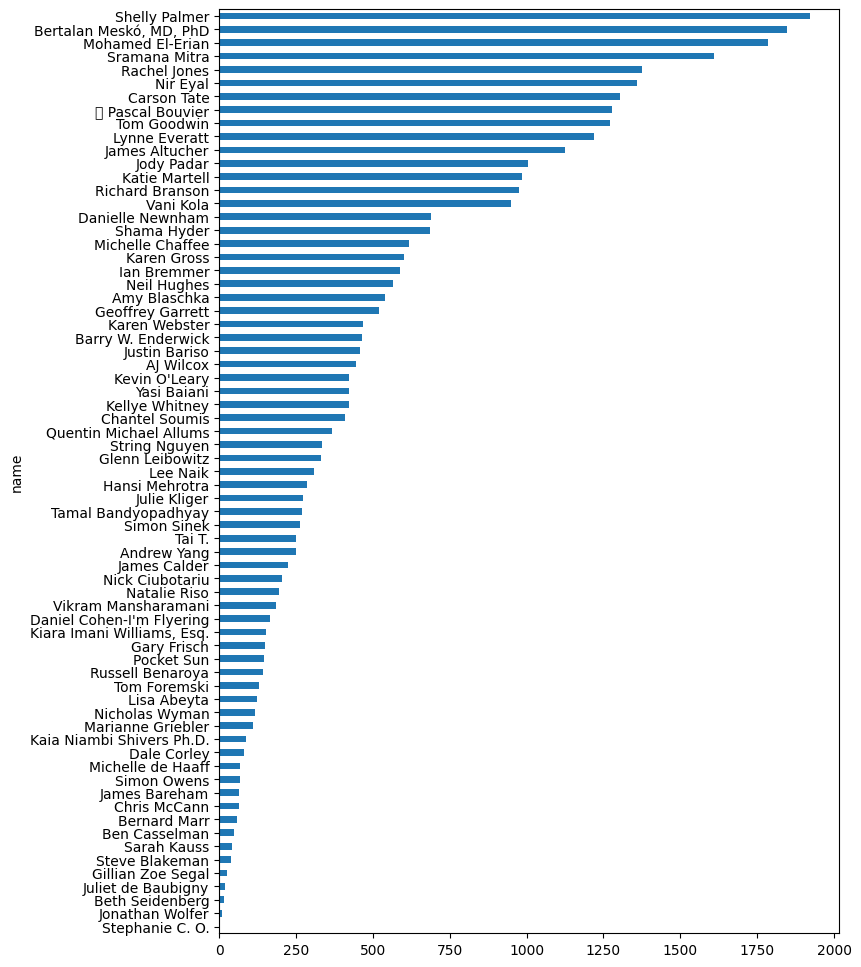

In [5]:
# count how many records we have for influencers
df.name.value_counts().sort_values().plot(kind='barh', figsize=(8,12))

# Create Small Sample DataFrame

In [6]:
sample_df = df.sample(100)[['name', 'headline', 'content']]

# drop records with missing content
sample_df = sample_df.dropna()

sample_df.head()

,name,headline,content
19353,Rachel Jones,Communications Consultant at Emerson Collective,"Professor Mmaki Jantjies (PhD) , here's a bri..."
28604,Shelly Palmer,CEO at The Palmer Group,"Under the measure, workers must be designated ..."
11363,Lynne Everatt,Author of The 5-Minute Recharge and Acts of Fr...,"Today we’re better off in a material sense, bu..."
30744,Andrew Yang,Candidate for NYC Mayor in 2021 (D) at Yangfor...,It is impossible to overstate the positive imp...
11276,Lynne Everatt,Author of The 5-Minute Recharge and Acts of Fr...,Want to give your relationship a booster shot?...


# Custom Functions

As anyone who has done any sort of data engineering, or even just basic data prep
before modeling knows, setting up custom functions that are modular and repeatable
is not only valuable it's best practice

Here we introduce an example template custom function that can be used for our 
purposes as well as later on when we introduce `H2O LLM DataStudio`


```
def custom_function(df, text_columns):
    
    # For text cleaning based functions use: 
    for column in text_columns: 
        df[column] = # add change code here 
    
    #For an example of how to filter the df see number_proportion_filter.py or numeric_filer.py 
    
    return df
```


# 🙈 Profanity Check




In [7]:
from profanity_check import predict_prob

threshold = 0.9

sample_df["profanity"] = predict_prob(sample_df["content"])

sample_df = sample_df[sample_df["profanity"] < threshold]
sample_df = sample_df.reset_index(drop=True)
sample_df.head()


,name,headline,content,profanity
0,Rachel Jones,Communications Consultant at Emerson Collective,"Professor Mmaki Jantjies (PhD) , here's a bri...",0.014745
1,Shelly Palmer,CEO at The Palmer Group,"Under the measure, workers must be designated ...",0.027932
2,Lynne Everatt,Author of The 5-Minute Recharge and Acts of Fr...,"Today we’re better off in a material sense, bu...",0.020130
3,Andrew Yang,Candidate for NYC Mayor in 2021 (D) at Yangfor...,It is impossible to overstate the positive imp...,0.012047
4,Lynne Everatt,Author of The 5-Minute Recharge and Acts of Fr...,Want to give your relationship a booster shot?...,0.101273


<Axes: >

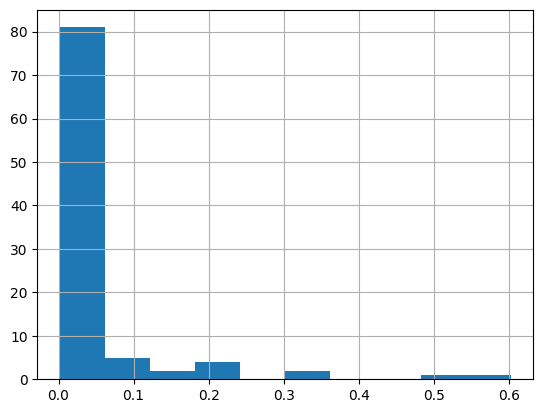

In [8]:
sample_df['profanity'].hist()

# 🧐 Text Quality Check

## Flesch Grade reading level

Depending on the task at hand, sometimes it's advantages to evaluate text and
language based on it's estimated reading level. One popular way to do this 
is with the Flesch-Kincaid grade level.  This is a grade formula in that a score
of 9.3 means that a ninth grader would be able to read the document.

The wikipedia article on this technique does a fair job explaining it:


<img src="static/flesch-kincade-scale.png" alt="drawing" width="800"/> 

Using the `textstat` python linvrary, we can approximate the reading level and
set our thresholds for what level we find ideal for our downstream NLP task.

In this case, we will limit the reading level between `2` and `10`, but many
other ranges are certainly possible

In [9]:
import textstat 

min_grade_level = 2
max_grade_level = 10

def check_quality(df, text_column):
    df["flesch_grade"] = df[text_column].apply(textstat.flesch_kincaid_grade)
    return df

cleaned = check_quality(sample_df, 'content')

# Filter to only those records with content between 2 and 10 grade level
cleaned = cleaned[(cleaned["flesch_grade"] >= min_grade_level) & (cleaned["flesch_grade"] <= max_grade_level)]
cleaned.head()


,name,headline,content,profanity,flesch_grade
2,Lynne Everatt,Author of The 5-Minute Recharge and Acts of Fr...,"Today we’re better off in a material sense, bu...",0.020130,7.2
3,Andrew Yang,Candidate for NYC Mayor in 2021 (D) at Yangfor...,It is impossible to overstate the positive imp...,0.012047,8.2
4,Lynne Everatt,Author of The 5-Minute Recharge and Acts of Fr...,Want to give your relationship a booster shot?...,0.101273,5.4
5,Richard Branson,Founder at Virgin Group,It’s been a pleasure working with Yanik Silver...,0.116892,4.2
8,AJ Wilcox,LinkedIn Ads Fanatic and Host of The LinkedIn ...,"Got to be a guest on the ""Inbound and Down"" po...",0.048126,8.1


<Axes: >

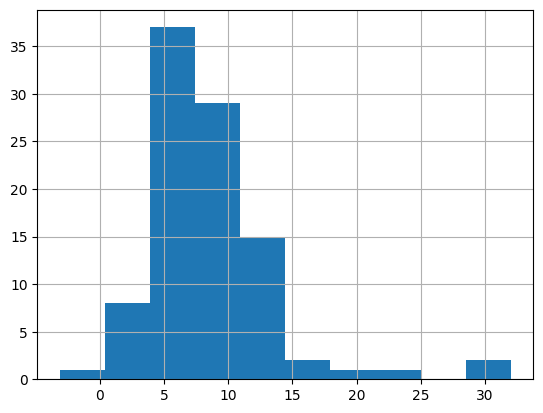

In [10]:
sample_df['flesch_grade'].hist()

# Run Preparation Pipeline

In [11]:
# Basic ETL

# Read in some additional utility functions

def remove_trailing_ws(df, text_columns):
    # For text cleaning based functions use: 
    for column in text_columns: 
        df[column] = df[column].str.strip()
    return df

def length_check_func(df,text_column, minLength,maxLength):
    df = df[(df[text_column].str.len() > int(minLength))]
    df = df[(df[text_column].str.len() < int(maxLength))]
    return df

def string_replace(df, text_columns, input, output):
    # For text cleaning based functions use: 
    for column in text_columns: 
        df[column] = df[column].str.replace(input, output)
    return df

# Keep Relevant Columns
cleaned = df[['name', 'headline', 'about', 'content', 'reactions']]

# Dropping missing
cleaned = cleaned.dropna()


# Text Cleaning (Minimal)
cleaned = string_replace(cleaned, ['content'], '…see more', '')
cleaned = remove_trailing_ws(cleaned, ['content'])

max_len = 10000
min_len = 1

cleaned = length_check_func(cleaned, 'content', min_len, max_len)


# Set thresholds

# Profanity Threshold
profanity_threshold = 0.9

# Target Reading Level
min_grade_level = 2
max_grade_level = 10

# Predict Probability of Profane Language
cleaned["profanity"] = predict_prob(cleaned["content"])

# Filter out Profane Language
cleaned = cleaned[cleaned["profanity"] < profanity_threshold]
cleaned = cleaned.reset_index(drop=True)

# Determine Reading Level
cleaned = check_quality(cleaned, 'content')

# Filter to only those records with content between a 2nd and 10th grader
cleaned = cleaned[(cleaned["flesch_grade"] >= min_grade_level) & (cleaned["flesch_grade"] <= max_grade_level)]
cleaned.head()


,name,headline,about,content,reactions,profanity,flesch_grade
1,Nicholas Wyman,CEO IWSI Group,Nicholas Wyman for the past 25 years has shone...,"National disability advocate Sara Hart Weir, ...",11,0.018358,8.8
2,Nicholas Wyman,CEO IWSI Group,Nicholas Wyman for the past 25 years has shone...,Exploring in this months Talent Management & H...,44,0.008754,8.8
3,Nicholas Wyman,CEO IWSI Group,Nicholas Wyman for the past 25 years has shone...,I count myself fortunate to have spent time wi...,22,0.000757,8.7
5,Nicholas Wyman,CEO IWSI Group,Nicholas Wyman for the past 25 years has shone...,Between the burgeoning unemployment rates and ...,16,0.056936,6.4
10,Nicholas Wyman,CEO IWSI Group,Nicholas Wyman for the past 25 years has shone...,Congratulations to Dr. Mark Goulston on recogn...,7,0.015959,9.5


In [12]:
num_dropped = df.shape[0] - cleaned.shape[0]

print(f"Lost a total of {num_dropped} records, or about {round(num_dropped/df.shape[0], 2) * 100}%")

Lost a total of 12722 records, or about 37.0%


# One Step Further

If we really want to talk like an influencer, perhaps we should also additionally limit the number of records
by the number of reactions the posts got. Let's take a look.

In [13]:
cleaned.sort_values('reactions')

,name,headline,about,content,reactions,profanity,flesch_grade
8978,Sramana Mitra,Founder and CEO of One Million by One Million ...,Sramana Mitra is the founder and CEO of One Mi...,At what stage should a #startup seek pre-see...,0,0.008001,7.2
8994,Sramana Mitra,Founder and CEO of One Million by One Million ...,Sramana Mitra is the founder and CEO of One Mi...,Can you get meetings with #VCs and #Angels ...,0,0.023579,8.8
159,Karen Gross,Educator/Author (children and adult books); Se...,"I'm an educator and author, writing books for ...",A piece I just wrote about a house party in Ma...,0,0.045217,4.8
175,Karen Gross,Educator/Author (children and adult books); Se...,"I'm an educator and author, writing books for ...",Consider enrolling in this course on Trauma An...,0,0.027191,7.3
183,Karen Gross,Educator/Author (children and adult books); Se...,"I'm an educator and author, writing books for ...",This suggests a new word to replace trauma in ...,0,0.003958,2.9
...,...,...,...,...,...,...,...
31737,Simon Sinek,Optimist and Author at Simon Sinek Inc.,Simon Sinek is an unshakable optimist who beli...,A mentor is not someone who walks ahead of us ...,103061,0.012749,3.0
4689,Richard Branson,Founder at Virgin Group,"Founder of the Virgin Group, which has gone on...","Happy 96th birthday to my biggest inspiration,...",104146,0.140939,6.3
4637,Richard Branson,Founder at Virgin Group,"Founder of the Virgin Group, which has gone on...","My wonderful wife, Joan. We’ve been leaning on...",117291,0.082846,2.7
31792,Simon Sinek,Optimist and Author at Simon Sinek Inc.,Simon Sinek is an unshakable optimist who beli...,A team is not a group of people who work toget...,118787,0.018277,2.9


We can see that the number of reactions these posts from 'influencers' received appear to go 
from zero (yikes!) all the way to over 330k. Noticeably, that single post with ~330k reactions
is simply `Helen is my kinda lady`.

The fact this post received so much attention given it's lack of context is also 
a warning that there could be exogenous latent variables, such as current events, pop culture, etc, that could be driving 
the number of reactions, not necessarily the content itself. 

Let's be just a little more analytical:

In [14]:
# Identify the 90th percentile of reactions over all posts
p90 = np.quantile(cleaned.reactions, 0.9)

print(f'The 90th percentile is {p90} reactions.')


The 90th percentile is 575.0 reactions.


For our purposes, let's focus on the top "performing" content to fine tune our model on

In [15]:
cleaned = cleaned[cleaned.reactions > p90]
cleaned.shape

(2127, 7)

We're now left with 2,127 high-quality data points to experiment with 
fine tuning on. 

Finally, let's ask h2oGPT to provide a title for our LinkedIn Influencer content.
This process is called `zero-shot text generation` (more on this later)

In [16]:
sample_df = cleaned.sample(5)

from gradio_client import Client
import ast
from pprint import pprint

# Dedicated h2oGPT
HOST_URL = "http://h2ogpt-web.h2ogpt.svc.cluster.local"
H2OGPT_KEY = "f74f043e-45fc-4dfe-9c33-55a4720427f6"
    
client = Client(HOST_URL)

from tqdm import tqdm
tqdm.pandas()

def generate_title(content):
    
    #try:
    summarize_prompt = 'You are a helpful, respectful and honest assistant the specializes in generating accurate titles of LinkedIn posts. Provide a title for the following post. The title should be a single sentence, not using bullet points. Only include the title in the response. The LinkedIn post is: ' + content
    kwargs = dict(
        instruction_nochat=summarize_prompt, 
        h2ogpt_key = H2OGPT_KEY)
    
    response = client.predict(str(dict(kwargs)), api_name='/submit_nochat_api')
    reply = ast.literal_eval(response)['response']
    #except:
        #reply = 'NA'
    return reply
        
sample_df['title'] = sample_df.progress_apply(lambda row :   generate_title(row['content']), axis=1)
sample_df.head()

Loaded as API: http://h2ogpt-web.h2ogpt.svc.cluster.local/ ✔


100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


,name,headline,about,content,reactions,profanity,flesch_grade,title
31918,Simon Sinek,Optimist and Author at Simon Sinek Inc.,Simon Sinek is an unshakable optimist who beli...,Bruce Deel has proven that when you take the r...,15452,0.041906,8.3,"""Empowering People Through Extreme Trust: Th..."
4835,Richard Branson,Founder at Virgin Group,"Founder of the Virgin Group, which has gone on...",It’s the words that count (not the spelling) ...,3228,0.024445,2.1,"""The Power of Dyslexic Thinking: Why Words M..."
31872,Simon Sinek,Optimist and Author at Simon Sinek Inc.,Simon Sinek is an unshakable optimist who beli...,Another week of LIVE online classes is up! Bec...,1139,0.015279,9.7,"""Unlock Your Potential: Live Online Classes ..."
29096,Pocket Sun,"Co-Founder & Managing Partner at SoGal, TEDx S...","An entrepreneur, investor, and futurist, Pocke...",Can’t describe my excitement right now!! Our ...,724,0.010127,9.2,"""SoGal Ventures' Seed Investment in Everlywe..."
5092,Richard Branson,Founder at Virgin Group,"Founder of the Virgin Group, which has gone on...",Waving goodbye to the Virgin Trains West Coa...,796,0.058986,6.0,"""Virgin Trains Bids Farewell to West Coast M..."


In [17]:
print(f'CONTENT:')
sample_df['content'].to_list()


CONTENT:


['Bruce Deel has proven that when you take the risk to trust people, they rise to the occasion. That\'s why he practices "extreme trust"\u200b through his organization City of Refuge, and why I am so excited to publish his book "Trust First"\u200b with #OptimismPress.',
 'It’s the words that count (not the spelling)  https://virg.in/58P   Made By Dyslexia',
 'Another week of LIVE online classes is up! Because they are LIVE, we offer classes at various times to help reach as many of you as we can. To sign up, visit  simonsinek.com/shop . Here’s what’s happening this week: MONDAY How to Lead Through Uncertainty @ 10am ET TUESDAY How to Pivot @ 7pm ET WEDNESDAY How to Build a Strong Culture @ 10am ET THURSDAY How to Deliver and Accept Feedback Effectively @ 10am ET Jumpstart Your WHY: Office Hours @ 3pm ET FRIDAY The Infinite Game: How to Advance Your Just Cause @ 9pm ET',
 'Can’t describe my excitement right now!! Our  SoGal Ventures  seed stage investment in March 2017 is now a $1.3 Bil

In [18]:
print(f'TITLE:')
sample_df['title'].to_list()

TITLE:


['  "Empowering People Through Extreme Trust: The City of Refuge Story and the Power of Trust First"',
 '  "The Power of Dyslexic Thinking: Why Words Matter More Than Spelling"',
 '  "Unlock Your Potential: Live Online Classes to Help You Thrive in Uncertainty"',
 '  "SoGal Ventures\' Seed Investment in Everlywell Now Valued at $1.3 Billion: A Journey to Breaking Standards and Making an Impact"',
 '  "Virgin Trains Bids Farewell to West Coast Mainline: A New Era Begins"']

In [19]:
# Optional alternative for fine tuning - create an instruction.
cleaned['instruction'] = ('Write a LinkedIn post in the style of an influencer whom has the title of '
  + cleaned['headline'] + ' and can be described by the following: ' 
  + cleaned['about'])

cleaned.sample(5)

,name,headline,about,content,reactions,profanity,flesch_grade,instruction
5247,Richard Branson,Founder at Virgin Group,"Founder of the Virgin Group, which has gone on...",Thrilled to celebrate Virgin Atlantic ’s new r...,4157,0.160989,6.8,Write a LinkedIn post in the style of an influ...
31937,Simon Sinek,Optimist and Author at Simon Sinek Inc.,Simon Sinek is an unshakable optimist who beli...,Great leaders don't see people as a commodity ...,15282,0.033452,9.7,Write a LinkedIn post in the style of an influ...
27972,Vani Kola,Managing Director at Kalaari,Vani Kola is the Founder and Managing Director...,Going to the family jeweller was the custom in...,583,0.021146,7.9,Write a LinkedIn post in the style of an influ...
6255,Mohamed El-Erian,"President at Queens'​ College, Cambridge",Dr Mohamed A. El-Erian is President of Queens'...,Happy Father's Day to all the dads out there. ...,3757,0.022549,6.1,Write a LinkedIn post in the style of an influ...
31955,Simon Sinek,Optimist and Author at Simon Sinek Inc.,Simon Sinek is an unshakable optimist who beli...,The greatest contribution of a leader is to ma...,71183,0.023041,7.6,Write a LinkedIn post in the style of an influ...


# Output Dataset

Now we're ready to store our data set out and experiment with fine-tuning
in Lab # 2 with H2O LLM Studio. 

In [20]:
#######################################################################################
# WARNING! This could take a very long time using the public facing h2oGPT endpoint. ##
#######################################################################################

# Apply to full data set
# cleaned['title'] = cleaned.progress_apply(lambda row :   generate_title(row['content']), axis=1)

# Output locally
# cleaned.to_csv('influencers_data_prepared.csv', index=False)

# 🎉 **CONGRATULATIONS!** You have completed this lab!
---

# 📚 **EXTENDED TASKS** 

# Understanding Enterprise Grade Dataprep with H2O LLM Data Studio


We've done an OK job manually looking through this data set in anticipation of 
fine-tuning a model on it. Specifically, we cleaned the text data, filtered it, 
and asked generative AI (h2oGPT) to create a title for each post. 

In practice, however, this won't scale very well. H2O.ai as created a tool called
`H2O LLM DataStudio` that enables you to run far more thorough data engineering 
pipelines for textual data. 

As the screenshot below shows, users can prepare their text data for numerous language 
modeling tasks. 

These include:

- Data Augmentation
- Text Cleaning
- Profanity Check 
- Text Quality Check
- Length Checker 
- Valid Question
- Pad Sequence
- Truncate Sequence by Score 
- Compression Ratio filter
- Boundary Marking
- Sensitive Info Checker
- RLHF Protection
- Language Understanding 
- Data Deduplication
- Toxicity Detection




---
<img src="static/h2o-data-studio.png" alt="drawing" width="800"/> 
---


---

# 🐍 Python CLI

Not only is LLM Data Studio a standalone Wave application and UI, it also 
supports programmatic data engineering pipelines. The following code snippet
provides an example of configuring a data engineering pipeline in Python.

For a deeper dive check out the blog post:
https://h2o.ai/blog/2023/streamlining-data-preparation-for-fine-tuning-of-large-language-models/

```python
# Importing required modules
from datastudio import prep
import pandas as pd

# Initializing configuration parameters for Question Answer Workflow
cfg = {
    "type": "qa",
    'config': { 
        'augmentation': [],
        "text_clean": {
            "cols": [],
            "funcs": ["new_line","whitespace","lower_case","urls","html","ascii"]
        },
        'length_checker': {
            'max_answer_length': 10000,
            'max_context_length': 10000,
            'max_question_length': 10000,
            'min_answer_length': 0,
            'min_context_length': 0,
            'min_question_length': 0
        },
        'padding': {'max_length': '600'},
        'profanity_checker': 0.3,
        'quality_checker': {'max_grade': 30, 'min_grade': 15},
        'relevance_checker': 0.15,
        'truncate': {'max_length': '10000', 'ratio': 0.15}
    },
    'dataflow': ['augmentation', 'text_cleaner', 'profanity_checker', 'length_checker', 
                 'grade_checker', 'qna_relevance', 'padding_sequence', 'truncate_sequence'],
    'datasets': [{
        'cols': {'answer': 'answer', 'context': 'context', 'question': 'question'},
        'path': ['input/qna.csv']
    }],
    'is_hum_bot': 0,
    "selected_aug_dataset": 0
}

# Executing data preparation pipeline
output_df = prep.prepare_dataset(cfg)

# Displaying output DataFrame
output_df.head()
```